In [65]:
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta # Date Functions
from pandas.plotting import register_matplotlib_converters # Adds plotting functions for calender dates
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense # Deep learning classes for recurrent and regular densely-connected layers


In [66]:
pip install yfinance

In [67]:
#load dataset
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=date_start, end=date_today)

# Taking a look at the shape of the dataset
print(df.shape)
df.head(5)

[*********************100%***********************]  1 of 1 completed
(3085, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [68]:
df.shape

(3085, 6)

In [69]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [70]:
df.duplicated().sum()

0

In [71]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-29,4602.859863,4637.299805,4589.660156,4631.600098,4631.600098,4239660000
2022-03-30,4624.200195,4627.770020,4581.319824,4602.450195,4602.450195,3665390000
2022-03-31,4599.020020,4603.069824,4530.410156,4530.410156,4530.410156,3782040000
2022-04-01,4540.319824,4548.700195,4507.569824,4545.859863,4545.859863,3828290000
2022-04-04,4547.970215,4583.500000,4539.209961,4582.640137,4582.640137,3833500000


Text(0, 0.5, 'Volume')

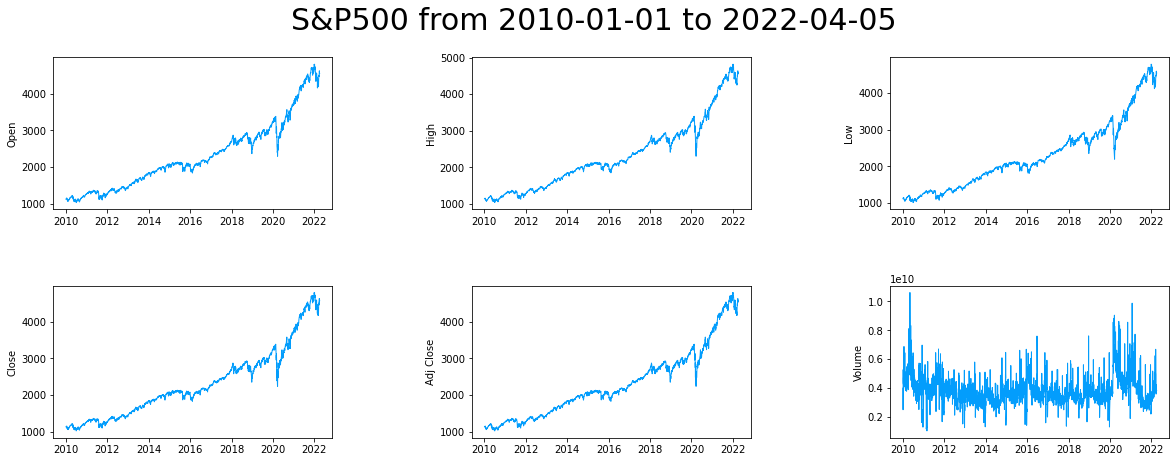

In [72]:
fig, ax = plt.subplots(2,3,figsize=(20, 7))
fig.suptitle(stockname + ' from '+ date_start + ' to ' + date_today,fontsize=30)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
ax[0,0].plot(df['Open'], color='#039dfc', label=stockname, linewidth=1.0)
ax[0,0].set_ylabel('Open', fontsize=10)

ax[0,1].plot(df['High'], color='#039dfc', label=stockname, linewidth=1.0)
ax[0,1].set_ylabel('High', fontsize=10)

ax[0,2].plot(df['Low'], color='#039dfc', label=stockname, linewidth=1.0)
ax[0,2].set_ylabel('Low', fontsize=10)

ax[1,0].plot(df['Close'], color='#039dfc', label=stockname, linewidth=1.0)
ax[1,0].set_ylabel('Close', fontsize=10)

ax[1,1].plot(df['Adj Close'], color='#039dfc', label=stockname, linewidth=1.0)
ax[1,1].set_ylabel('Adj Close', fontsize=10)

ax[1,2].plot(df['Volume'], color='#039dfc', label=stockname, linewidth=1.0)
ax[1,2].set_ylabel('Volume', fontsize=10)

Split dataset

In [73]:
# Feature Selection - Only Close Data
train_df = df.filter(['Close'])
data_unscaled = train_df.values

In [74]:
data_unscaled

array([[1132.98999023],
       [1136.52001953],
       [1137.14001465],
       ...,
       [4530.41015625],
       [4545.85986328],
       [4582.64013672]])

In [75]:
index_Close = train_df.columns.get_loc("Close")
# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [76]:
sequence_length = 50
train_data_len = math.ceil(np_data.shape[0] * 0.8)

In [77]:
train_data = np_data[0:train_data_len, :]


In [78]:
test_data = np_data[train_data_len:, :]

In [79]:
train_data.shape

(2468, 1)

In [80]:
test_data.shape

(617, 1)

In [81]:
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [82]:
x_train.shape

(2418, 50, 1)

In [83]:
x_test.shape

(567, 50, 1)

In [84]:
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0.5892188055453789
0.5892188055453789


Design the Model Architecture

In [85]:
model = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [86]:
model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
152/152 [==============================] - 7s 23ms/step - loss: 0.0021
Epoch 2/25
152/152 [==============================] - 4s 23ms/step - loss: 1.2111e-04
Epoch 3/25
152/152 [==============================] - 4s 23ms/step - loss: 1.1210e-04
Epoch 4/25
152/152 [==============================] - 4s 23ms/step - loss: 1.0801e-04
Epoch 5/25
152/152 [==============================] - 3s 23ms/step - loss: 1.0610e-04
Epoch 6/25
152/152 [==============================] - 4s 23ms/step - loss: 1.0274e-04
Epoch 7/25
152/152 [==============================] - 4s 23ms/step - loss: 1.0392e-04
Epoch 8/25
152/152 [==============================] - 4s 23ms/step - loss: 1.2665e-04
Epoch 9/25
152/152 [==============================] - 4s 23ms/step - loss: 9.1139e-05
Epoch 10/25
152/152 [==============================] - 4s 23ms/step - loss: 8.3467e-05
Epoch 11/25
152/152 [==============================] - 4s 23ms/step - loss: 7.3831e-05
Epoch 12/25
152/152 [==============================] - 4

In [88]:
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

In [89]:
from sklearn.metrics import r2_score
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

print('R2: ',r2_score(y_test_unscaled,y_pred))

Median Absolute Error (MAE): 42.49
Mean Absolute Percentage Error (MAPE): 1.21 %
Median Absolute Percentage Error (MDAPE): 0.8 %
R2:  0.990244193971008


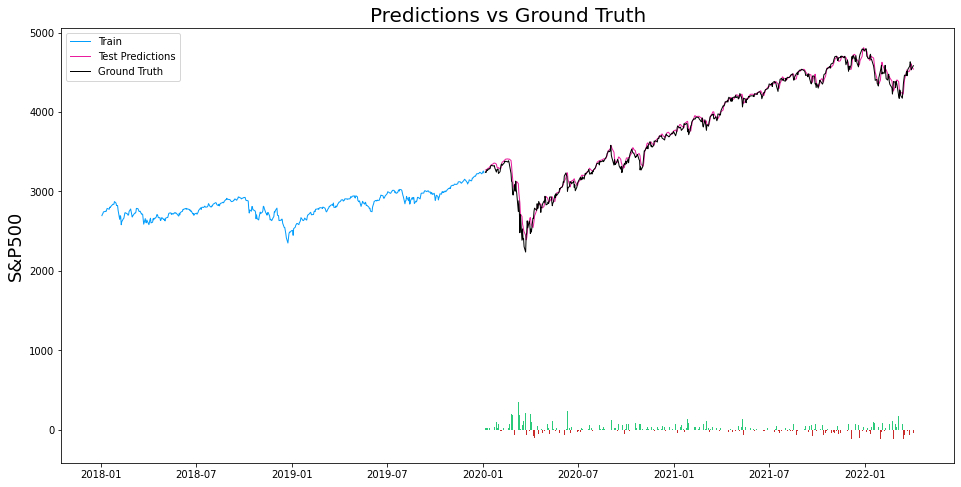

In [105]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = train_df[:train_data_len+sequence_length]
valid = train_df[train_data_len+sequence_length:]
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax = plt.subplots(figsize=(16, 8), sharex=True)

plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(train["Close"], color="#039dfc", linewidth=1.0)
plt.plot(valid["Predictions"], color="#E91D9E", linewidth=1.0)
plt.plot(valid["Close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")


# Create the bar plot with the differences
valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

 ref: https://github.com/flo7up/relataly-public-python-tutorials/blob/master/003%20Time%20Series%20Forecasting%20-%20Univariate%20Model%20using%20Recurrent%20Neural%20Networks.ipynb

In [98]:
len(train_df[train_data_len:])

617

In [99]:
567+50

617